# Import librairies et modules

In [132]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()

user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
dbname = os.getenv("DB_NAME")

DATABASE_URL = f"postgresql://{user}:{password}@{host}:{port}/{dbname}?sslmode=require"

def fetch_table_from_trafic_db(table_name) :
    '''
        Récupère toutes les données d'une table spécifique depuis la base de données de trafic.
        
        Args:
            table_name (str): Le nom de la table à récupérer.
            
        Returns:
            pd.DataFrame: Un DataFrame contenant les données de la table demandée.
    '''
    engine = create_engine(DATABASE_URL)
    query = f"SELECT * FROM {table_name};" 
    df = pd.read_sql(query, engine)
    return df


# Import df

In [133]:
df_events = fetch_table_from_trafic_db('events_data')

In [134]:
df_matching_troncon = fetch_table_from_trafic_db('matching_event_troncon')

In [135]:
df_pollution_data = fetch_table_from_trafic_db('pollution_data')

In [ ]:
df_trafic = fetch_table_from_trafic_db('trafic_routier')

In [7]:
df_weather_data = fetch_table_from_trafic_db('weather_data')

In [8]:
df_holidays = fetch_table_from_trafic_db('weekday_holidays')

# Jointures

## Trafic + holidays

### Explo & clean up df_holidays

In [9]:
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   dates        685 non-null    object
 1   jour         685 non-null    object
 2   is_vacances  685 non-null    int64 
 3   is_ferie     685 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 21.5+ KB


In [10]:
df_holidays.head(2)

,dates,jour,is_vacances,is_ferie
0,2025-02-15,Saturday,1,0
1,2025-02-16,Sunday,1,0


In [11]:
df_holidays['dates'] = pd.to_datetime(df_holidays['dates'])

In [12]:
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   dates        685 non-null    datetime64[ns]
 1   jour         685 non-null    object        
 2   is_vacances  685 non-null    int64         
 3   is_ferie     685 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 21.5+ KB


### Explo & clean_up df_trafic

In [13]:
df_trafic.head(2)

,id_technique,id,debit,longueur,taux_occupation,code_couleur,nom_du_troncon,etat_du_trafic,temps_de_parcours,vitesse,geo_point_2d,geometrie,shape_geo,horodatage,type_geo,coordinates_geo,horodatage_date
0,1021-20250221T195200,1021,360,349,4.5,3,Riviere I2,Fluide,67,19,"{47.173182364085264,-1.54324767771205}","{{-1.543455846431246,47.174749993156965},{-1.5...",LineString,2025-02-21 19:52:00,Point,"{-1.54324767771205,47.173182364085264}",2025-02-21
1,5471-20250221T195200,5471,-1,578,-1.0,2,Vannes P7,Indéterminé,-1,-1,"{47.24509293713415,-1.6009796268635674}","{{-1.597841857973176,47.24360736425447},{-1.60...",LineString,2025-02-21 19:52:00,Point,"{-1.6009796268635674,47.24509293713415}",2025-02-21


In [14]:
df_trafic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554761 entries, 0 to 1554760
Data columns (total 17 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   id_technique       1554761 non-null  object        
 1   id                 1554761 non-null  int64         
 2   debit              1554761 non-null  int64         
 3   longueur           1554761 non-null  int64         
 4   taux_occupation    1554761 non-null  float64       
 5   code_couleur       1554761 non-null  int64         
 6   nom_du_troncon     1554761 non-null  object        
 7   etat_du_trafic     1554761 non-null  object        
 8   temps_de_parcours  1554761 non-null  int64         
 9   vitesse            1554761 non-null  int64         
 10  geo_point_2d       1554761 non-null  object        
 11  geometrie          1554761 non-null  object        
 12  shape_geo          1554761 non-null  object        
 13  horodatage         1554761 

In [15]:
df_trafic['horodatage_date'] = pd.to_datetime(df_trafic['horodatage_date'])

### Merge

In [16]:
df_trafic_holidays = pd.merge(df_trafic, df_holidays,
                              how = 'left',
                              left_on = df_trafic['horodatage_date'],
                              right_on = 'dates')

#### Check & Clean

In [17]:
df_trafic_holidays.head()

,id_technique,id,debit,longueur,taux_occupation,code_couleur,nom_du_troncon,etat_du_trafic,temps_de_parcours,vitesse,...,geometrie,shape_geo,horodatage,type_geo,coordinates_geo,horodatage_date,dates,jour,is_vacances,is_ferie
0,1021-20250221T195200,1021,360,349,4.5,3,Riviere I2,Fluide,67,19,...,"{{-1.543455846431246,47.174749993156965},{-1.5...",LineString,2025-02-21 19:52:00,Point,"{-1.54324767771205,47.173182364085264}",2025-02-21,2025-02-21,Friday,1,0
1,5471-20250221T195200,5471,-1,578,-1.0,2,Vannes P7,Indéterminé,-1,-1,...,"{{-1.597841857973176,47.24360736425447},{-1.60...",LineString,2025-02-21 19:52:00,Point,"{-1.6009796268635674,47.24509293713415}",2025-02-21,2025-02-21,Friday,1,0
2,6006-20250221T195200,6006,120,411,3.3,3,Republique P1,Fluide,91,16,...,"{{-1.548721945476285,47.19149418127721},{-1.54...",LineString,2025-02-21 19:52:00,Point,"{-1.547764551534212,47.18995864597197}",2025-02-21,2025-02-21,Friday,1,0
3,7128-20250221T195200,7128,300,180,3.7,3,Ingres P1,Fluide,35,19,...,"{{-1.595242031038862,47.22218110593763},{-1.59...",LineString,2025-02-21 19:52:00,Point,"{-1.5940704323951738,47.222021339359344}",2025-02-21,2025-02-21,Friday,1,0
4,2128-20250221T195200,2128,480,208,5.8,3,Ingres I3,Fluide,39,19,...,"{{-1.595406686815851,47.221907195976286},{-1.5...",LineString,2025-02-21 19:52:00,Point,"{-1.5940606464968337,47.2217086294291}",2025-02-21,2025-02-21,Friday,1,0


#df_trafic_holidays.drop(columns=['dates'],inplace = True)

In [18]:
df_trafic_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554761 entries, 0 to 1554760
Data columns (total 21 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   id_technique       1554761 non-null  object        
 1   id                 1554761 non-null  int64         
 2   debit              1554761 non-null  int64         
 3   longueur           1554761 non-null  int64         
 4   taux_occupation    1554761 non-null  float64       
 5   code_couleur       1554761 non-null  int64         
 6   nom_du_troncon     1554761 non-null  object        
 7   etat_du_trafic     1554761 non-null  object        
 8   temps_de_parcours  1554761 non-null  int64         
 9   vitesse            1554761 non-null  int64         
 10  geo_point_2d       1554761 non-null  object        
 11  geometrie          1554761 non-null  object        
 12  shape_geo          1554761 non-null  object        
 13  horodatage         1554761 

## Trafic + holidays + weather

#### Explo & clean_up weather table

In [19]:
df_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1344 non-null   datetime64[ns]
 1   temperature_2m  1344 non-null   float64       
 2   visibility      1344 non-null   float64       
 3   precipitation   1344 non-null   float64       
 4   wind_speed_10m  1344 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 52.6 KB


In [20]:
df_weather_data.head(5)

,date,temperature_2m,visibility,precipitation,wind_speed_10m
0,2025-02-15 22:00:00,3.9805,24140.0,0.0,10.144082
1,2025-02-15 23:00:00,3.2305,24140.0,0.0,11.019764
2,2025-02-16 00:00:00,2.8305,24140.0,0.0,11.885453
3,2025-02-16 01:00:00,2.2805,24140.0,0.0,11.019764
4,2025-02-16 02:00:00,1.8805,24140.0,0.0,10.495713


#### Explo & clean_up df_trafic_holidays

In [21]:
df_trafic_holidays.head()

,id_technique,id,debit,longueur,taux_occupation,code_couleur,nom_du_troncon,etat_du_trafic,temps_de_parcours,vitesse,...,geometrie,shape_geo,horodatage,type_geo,coordinates_geo,horodatage_date,dates,jour,is_vacances,is_ferie
0,1021-20250221T195200,1021,360,349,4.5,3,Riviere I2,Fluide,67,19,...,"{{-1.543455846431246,47.174749993156965},{-1.5...",LineString,2025-02-21 19:52:00,Point,"{-1.54324767771205,47.173182364085264}",2025-02-21,2025-02-21,Friday,1,0
1,5471-20250221T195200,5471,-1,578,-1.0,2,Vannes P7,Indéterminé,-1,-1,...,"{{-1.597841857973176,47.24360736425447},{-1.60...",LineString,2025-02-21 19:52:00,Point,"{-1.6009796268635674,47.24509293713415}",2025-02-21,2025-02-21,Friday,1,0
2,6006-20250221T195200,6006,120,411,3.3,3,Republique P1,Fluide,91,16,...,"{{-1.548721945476285,47.19149418127721},{-1.54...",LineString,2025-02-21 19:52:00,Point,"{-1.547764551534212,47.18995864597197}",2025-02-21,2025-02-21,Friday,1,0
3,7128-20250221T195200,7128,300,180,3.7,3,Ingres P1,Fluide,35,19,...,"{{-1.595242031038862,47.22218110593763},{-1.59...",LineString,2025-02-21 19:52:00,Point,"{-1.5940704323951738,47.222021339359344}",2025-02-21,2025-02-21,Friday,1,0
4,2128-20250221T195200,2128,480,208,5.8,3,Ingres I3,Fluide,39,19,...,"{{-1.595406686815851,47.221907195976286},{-1.5...",LineString,2025-02-21 19:52:00,Point,"{-1.5940606464968337,47.2217086294291}",2025-02-21,2025-02-21,Friday,1,0


In [22]:
# Arrondir à l'heure la plus proche pour matcher avec le dataset weather
df_trafic_holidays['rounded_horodatage'] = df_trafic_holidays['horodatage'].dt.round('H')

<ipython-input-22-e31be1a6e68c>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_trafic_holidays['rounded_horodatage'] = df_trafic_holidays['horodatage'].dt.round('H')


#### Merge

In [23]:
df_trafic_holidays_weather = pd.merge(df_trafic_holidays,df_weather_data,
                                                      how = 'left',
                                                      left_on = 'rounded_horodatage',
                                                      right_on = 'date')

In [24]:
df_trafic_holidays_weather.head()

,id_technique,id,debit,longueur,taux_occupation,code_couleur,nom_du_troncon,etat_du_trafic,temps_de_parcours,vitesse,...,dates,jour,is_vacances,is_ferie,rounded_horodatage,date,temperature_2m,visibility,precipitation,wind_speed_10m
0,1021-20250221T195200,1021,360,349,4.5,3,Riviere I2,Fluide,67,19,...,2025-02-21,Friday,1,0,2025-02-21 20:00:00,2025-02-21 20:00:00,12.9805,24140.0,0.2,20.240196
1,5471-20250221T195200,5471,-1,578,-1.0,2,Vannes P7,Indéterminé,-1,-1,...,2025-02-21,Friday,1,0,2025-02-21 20:00:00,2025-02-21 20:00:00,12.9805,24140.0,0.2,20.240196
2,6006-20250221T195200,6006,120,411,3.3,3,Republique P1,Fluide,91,16,...,2025-02-21,Friday,1,0,2025-02-21 20:00:00,2025-02-21 20:00:00,12.9805,24140.0,0.2,20.240196
3,7128-20250221T195200,7128,300,180,3.7,3,Ingres P1,Fluide,35,19,...,2025-02-21,Friday,1,0,2025-02-21 20:00:00,2025-02-21 20:00:00,12.9805,24140.0,0.2,20.240196
4,2128-20250221T195200,2128,480,208,5.8,3,Ingres I3,Fluide,39,19,...,2025-02-21,Friday,1,0,2025-02-21 20:00:00,2025-02-21 20:00:00,12.9805,24140.0,0.2,20.240196


In [25]:
df_trafic_holidays_weather.drop(columns=['date'],inplace = True)

In [26]:
df_trafic_holidays_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554761 entries, 0 to 1554760
Data columns (total 26 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id_technique        1554761 non-null  object        
 1   id                  1554761 non-null  int64         
 2   debit               1554761 non-null  int64         
 3   longueur            1554761 non-null  int64         
 4   taux_occupation     1554761 non-null  float64       
 5   code_couleur        1554761 non-null  int64         
 6   nom_du_troncon      1554761 non-null  object        
 7   etat_du_trafic      1554761 non-null  object        
 8   temps_de_parcours   1554761 non-null  int64         
 9   vitesse             1554761 non-null  int64         
 10  geo_point_2d        1554761 non-null  object        
 11  geometrie           1554761 non-null  object        
 12  shape_geo           1554761 non-null  object        
 13  horodatage  

## Trafic + holidays + weather + pollution

#### Explo & clean_up pollution

In [27]:
df_pollution_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gml_id            51 non-null     object 
 1   date_ech          51 non-null     object 
 2   code_qual         51 non-null     int64  
 3   lib_qual          51 non-null     object 
 4   coul_qual         51 non-null     object 
 5   date_dif          51 non-null     object 
 6   source            51 non-null     object 
 7   type_zone         51 non-null     object 
 8   code_zone         51 non-null     int64  
 9   lib_zone          51 non-null     object 
 10  code_no2          51 non-null     int64  
 11  code_so2          51 non-null     int64  
 12  code_o3           51 non-null     int64  
 13  code_pm10         51 non-null     int64  
 14  code_pm25         51 non-null     int64  
 15  x_wgs84           51 non-null     float64
 16  y_wgs84           51 non-null     float64
 17 

In [28]:
df_pollution_data['date_ech'] = pd.to_datetime(df_pollution_data['date_ech'])

In [29]:
df_pollution_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gml_id            51 non-null     object        
 1   date_ech          51 non-null     datetime64[ns]
 2   code_qual         51 non-null     int64         
 3   lib_qual          51 non-null     object        
 4   coul_qual         51 non-null     object        
 5   date_dif          51 non-null     object        
 6   source            51 non-null     object        
 7   type_zone         51 non-null     object        
 8   code_zone         51 non-null     int64         
 9   lib_zone          51 non-null     object        
 10  code_no2          51 non-null     int64         
 11  code_so2          51 non-null     int64         
 12  code_o3           51 non-null     int64         
 13  code_pm10         51 non-null     int64         
 14  code_pm25         51 non-nul

In [30]:
df_pollution_data.head()

,gml_id,date_ech,code_qual,lib_qual,coul_qual,date_dif,source,type_zone,code_zone,lib_zone,...,x_wgs84,y_wgs84,x_reg,y_reg,epsg_reg,etat_indice,geom_type,geom_coordinates,geo_point_2d_lon,geo_point_2d_lat
0,ind_pays_de_la_loire.14923,2025-03-02,2,moyen,#50ccaa,2025-03-03,Air Pays de la Loire,commune,44109,Nantes,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044
1,ind_pays_de_la_loire.14027,2025-03-04,3,dégradé,#f0e641,2025-03-05,Air Pays de la Loire,commune,44109,Nantes,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044
2,ind_pays_de_la_loire.10884,2025-03-12,2,moyen,#50ccaa,2025-03-13,Air Pays de la Loire,commune,44109,Nantes,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044
3,ind_pays_de_la_loire.2805,2025-04-01,2,moyen,#50ccaa,2025-04-02,Air Pays de la Loire,commune,44109,Nantes,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044
4,ind_pays_de_la_loire.15733,2025-02-28,2,moyen,#50ccaa,2025-03-01,Air Pays de la Loire,commune,44109,Nantes,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044


In [31]:
df_trafic_holidays_weather_pollution = pd.merge(df_trafic_holidays_weather,df_pollution_data,
                                                how = 'left', 
                                                left_on = 'horodatage_date',
                                                right_on = 'date_ech')

In [32]:
df_trafic_holidays_weather_pollution.head()

,id_technique,id,debit,longueur,taux_occupation,code_couleur,nom_du_troncon,etat_du_trafic,temps_de_parcours,vitesse,...,x_wgs84,y_wgs84,x_reg,y_reg,epsg_reg,etat_indice,geom_type,geom_coordinates,geo_point_2d_lon,geo_point_2d_lat
0,1021-20250221T195200,1021,360,349,4.5,3,Riviere I2,Fluide,67,19,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044
1,5471-20250221T195200,5471,-1,578,-1.0,2,Vannes P7,Indéterminé,-1,-1,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044
2,6006-20250221T195200,6006,120,411,3.3,3,Republique P1,Fluide,91,16,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044
3,7128-20250221T195200,7128,300,180,3.7,3,Ingres P1,Fluide,35,19,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044
4,2128-20250221T195200,2128,480,208,5.8,3,Ingres I3,Fluide,39,19,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044


In [33]:
df_trafic_holidays_weather_pollution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554761 entries, 0 to 1554760
Data columns (total 51 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id_technique        1554761 non-null  object        
 1   id                  1554761 non-null  int64         
 2   debit               1554761 non-null  int64         
 3   longueur            1554761 non-null  int64         
 4   taux_occupation     1554761 non-null  float64       
 5   code_couleur        1554761 non-null  int64         
 6   nom_du_troncon      1554761 non-null  object        
 7   etat_du_trafic      1554761 non-null  object        
 8   temps_de_parcours   1554761 non-null  int64         
 9   vitesse             1554761 non-null  int64         
 10  geo_point_2d        1554761 non-null  object        
 11  geometrie           1554761 non-null  object        
 12  shape_geo           1554761 non-null  object        
 13  horodatage  

## Trafic + holidays + weather + pollution + event

#### Explo & clean_up event

In [34]:
df_matching_troncon

,index,id_du_troncon,nom_du_troncon,has_event_near_troncon,event_location_name,event_location_id
0,27,97,St Joseph I04,1,Parc des Expositions de la Beaujoire,34310089
1,171,5208,Viviani P2,1,Palais des Sports Beaulieu,57179132
2,251,98,St Joseph I05,1,Stade de la Beaujoire Louis Fonteneau,95545941
3,317,139,Bureau I,1,STEREOLUX,21547859
4,465,5207,Viviani P1,1,Palais des Sports Beaulieu,57179132
5,568,5139,Bureau P,1,STEREOLUX,21547859
6,612,5319,Bonduelle P1,1,Cité internationale des Congrès,47538434
7,657,5131,Carnot P2,1,Cité internationale des Congrès,47538434
8,658,131,Carnot I1,1,Cité internationale des Congrès,47538434
9,659,319,Bonduelle I1,1,Cité internationale des Congrès,47538434


In [35]:
lieux_spectacle_gde_capacite = [
    "Stade de la Beaujoire Louis Fonteneau",
    "Cité internationale des Congrès",
    "Palais des Sports Beaulieu",
]

df_matching_troncon_filtered = df_matching_troncon[df_matching_troncon['event_location_name'].isin(lieux_spectacle_gde_capacite)]


In [36]:
df_matching_troncon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   19 non-null     int64 
 1   id_du_troncon           19 non-null     int64 
 2   nom_du_troncon          19 non-null     object
 3   has_event_near_troncon  19 non-null     int64 
 4   event_location_name     19 non-null     object
 5   event_location_id       19 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 1.0+ KB


In [37]:
df_matching_troncon['event_location_id'] = df_matching_troncon['event_location_id'].astype('str')

In [38]:
df_matching_troncon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   19 non-null     int64 
 1   id_du_troncon           19 non-null     int64 
 2   nom_du_troncon          19 non-null     object
 3   has_event_near_troncon  19 non-null     int64 
 4   event_location_name     19 non-null     object
 5   event_location_id       19 non-null     object
dtypes: int64(3), object(3)
memory usage: 1.0+ KB


In [39]:
df_matching_troncon.head()

,index,id_du_troncon,nom_du_troncon,has_event_near_troncon,event_location_name,event_location_id
0,27,97,St Joseph I04,1,Parc des Expositions de la Beaujoire,34310089
1,171,5208,Viviani P2,1,Palais des Sports Beaulieu,57179132
2,251,98,St Joseph I05,1,Stade de la Beaujoire Louis Fonteneau,95545941
3,317,139,Bureau I,1,STEREOLUX,21547859
4,465,5207,Viviani P1,1,Palais des Sports Beaulieu,57179132


In [40]:
df_events.head()

,name,description,startdate,enddate,location_name,address,city,postalcode,location_uid,coordinates_geo,event_id
0,Football : FC Nantes / Paris SG,Match - 29e journée - Ligue 1 - Saison 2024/2025,2025-04-13 17:00:00,2025-04-13 19:00:00,Stade de la Beaujoire Louis Fonteneau,"330 Route de Saint Joseph, Nantes",Nantes,44300,95545941,"{-1.527812, 47.25867}",926afe1f-3bcc-4cc1-a2bd-3597dd36d86d
1,Football : FC Nantes / Toulouse FC,Match - 31e journée - Ligue 1 - Saison 2024/2025,2025-04-27 17:00:00,2025-04-27 19:00:00,Stade de la Beaujoire Louis Fonteneau,"330 Route de Saint Joseph, Nantes",Nantes,44300,95545941,"{-1.527812, 47.25867}",19bb79da-1c20-41a2-a53d-c45bcae5a0ce
2,Blandine Lehout - La Vie de ta mère,Blandine Lehout - La Vie de ta mère,2025-10-01 20:00:00,2025-10-01 22:30:00,Cité internationale des Congrès,"5 Rue de Valmy, Nantes",Nantes,44000,47538434,"{-1.544058, 47.213314}",da51b672-08bc-49e6-bcd6-516090c48e77
3,Alexandre Kominek - Bâtard sensible,Alexandre Kominek - Bâtard sensible,2025-03-01 20:30:00,2025-03-01 22:00:00,Cité internationale des Congrès,"5 Rue de Valmy, Nantes",Nantes,44000,47538434,"{-1.544058, 47.213314}",209c09e0-8d45-4429-ab15-7e1bf979f9c1
4,Comédie Le Clan des divorcées,Comédie Le Clan des divorcées,2025-03-02 15:00:00,2025-03-02 16:40:00,Cité internationale des Congrès,"5 Rue de Valmy, Nantes",Nantes,44000,47538434,"{-1.544058, 47.213314}",2eae861f-2e7f-4ff4-8c77-8f72b719fb23


In [41]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             134 non-null    object        
 1   description      134 non-null    object        
 2   startdate        134 non-null    datetime64[ns]
 3   enddate          134 non-null    datetime64[ns]
 4   location_name    134 non-null    object        
 5   address          134 non-null    object        
 6   city             134 non-null    object        
 7   postalcode       134 non-null    object        
 8   location_uid     134 non-null    object        
 9   coordinates_geo  134 non-null    object        
 10  event_id         134 non-null    object        
dtypes: datetime64[ns](2), object(9)
memory usage: 11.6+ KB


In [42]:
df_events['location_uid'] = df_events['location_uid'].astype('str')

In [43]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             134 non-null    object        
 1   description      134 non-null    object        
 2   startdate        134 non-null    datetime64[ns]
 3   enddate          134 non-null    datetime64[ns]
 4   location_name    134 non-null    object        
 5   address          134 non-null    object        
 6   city             134 non-null    object        
 7   postalcode       134 non-null    object        
 8   location_uid     134 non-null    object        
 9   coordinates_geo  134 non-null    object        
 10  event_id         134 non-null    object        
dtypes: datetime64[ns](2), object(9)
memory usage: 11.6+ KB


In [44]:
df_event_troncon = pd.merge(df_events,df_matching_troncon,
                            how = 'left', 
                            left_on = 'location_uid',
                            right_on = 'event_location_id')

In [45]:
df_event_troncon.head()

,name,description,startdate,enddate,location_name,address,city,postalcode,location_uid,coordinates_geo,event_id,index,id_du_troncon,nom_du_troncon,has_event_near_troncon,event_location_name,event_location_id
0,Football : FC Nantes / Paris SG,Match - 29e journée - Ligue 1 - Saison 2024/2025,2025-04-13 17:00:00,2025-04-13 19:00:00,Stade de la Beaujoire Louis Fonteneau,"330 Route de Saint Joseph, Nantes",Nantes,44300,95545941,"{-1.527812, 47.25867}",926afe1f-3bcc-4cc1-a2bd-3597dd36d86d,251.0,98.0,St Joseph I05,1.0,Stade de la Beaujoire Louis Fonteneau,95545941
1,Football : FC Nantes / Paris SG,Match - 29e journée - Ligue 1 - Saison 2024/2025,2025-04-13 17:00:00,2025-04-13 19:00:00,Stade de la Beaujoire Louis Fonteneau,"330 Route de Saint Joseph, Nantes",Nantes,44300,95545941,"{-1.527812, 47.25867}",926afe1f-3bcc-4cc1-a2bd-3597dd36d86d,800.0,5098.0,St Joseph P09,1.0,Stade de la Beaujoire Louis Fonteneau,95545941
2,Football : FC Nantes / Paris SG,Match - 29e journée - Ligue 1 - Saison 2024/2025,2025-04-13 17:00:00,2025-04-13 19:00:00,Stade de la Beaujoire Louis Fonteneau,"330 Route de Saint Joseph, Nantes",Nantes,44300,95545941,"{-1.527812, 47.25867}",926afe1f-3bcc-4cc1-a2bd-3597dd36d86d,801.0,5097.0,St Joseph P10,1.0,Stade de la Beaujoire Louis Fonteneau,95545941
3,Football : FC Nantes / Paris SG,Match - 29e journée - Ligue 1 - Saison 2024/2025,2025-04-13 17:00:00,2025-04-13 19:00:00,Stade de la Beaujoire Louis Fonteneau,"330 Route de Saint Joseph, Nantes",Nantes,44300,95545941,"{-1.527812, 47.25867}",926afe1f-3bcc-4cc1-a2bd-3597dd36d86d,849.0,97.0,St Joseph I04,1.0,Stade de la Beaujoire Louis Fonteneau,95545941
4,Football : FC Nantes / Toulouse FC,Match - 31e journée - Ligue 1 - Saison 2024/2025,2025-04-27 17:00:00,2025-04-27 19:00:00,Stade de la Beaujoire Louis Fonteneau,"330 Route de Saint Joseph, Nantes",Nantes,44300,95545941,"{-1.527812, 47.25867}",19bb79da-1c20-41a2-a53d-c45bcae5a0ce,251.0,98.0,St Joseph I05,1.0,Stade de la Beaujoire Louis Fonteneau,95545941


In [46]:
df_event_troncon.drop(columns=['index', 'nom_du_troncon', 'event_location_name', 'event_location_id'], inplace = True)

In [47]:
df_event_troncon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    500 non-null    object        
 1   description             500 non-null    object        
 2   startdate               500 non-null    datetime64[ns]
 3   enddate                 500 non-null    datetime64[ns]
 4   location_name           500 non-null    object        
 5   address                 500 non-null    object        
 6   city                    500 non-null    object        
 7   postalcode              500 non-null    object        
 8   location_uid            500 non-null    object        
 9   coordinates_geo         500 non-null    object        
 10  event_id                500 non-null    object        
 11  id_du_troncon           489 non-null    float64       
 12  has_event_near_troncon  489 non-null    float64   

In [48]:
df_event_troncon['id_du_troncon'] = df_event_troncon['id_du_troncon'].astype('str')

In [49]:
df_event_troncon['id_du_troncon'] = df_event_troncon['id_du_troncon'].str.replace('.0', '')

#### Merge

In [50]:
df_trafic_holidays_weather_pollution.head()

,id_technique,id,debit,longueur,taux_occupation,code_couleur,nom_du_troncon,etat_du_trafic,temps_de_parcours,vitesse,...,x_wgs84,y_wgs84,x_reg,y_reg,epsg_reg,etat_indice,geom_type,geom_coordinates,geo_point_2d_lon,geo_point_2d_lat
0,1021-20250221T195200,1021,360,349,4.5,3,Riviere I2,Fluide,67,19,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044
1,5471-20250221T195200,5471,-1,578,-1.0,2,Vannes P7,Indéterminé,-1,-1,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044
2,6006-20250221T195200,6006,120,411,3.3,3,Republique P1,Fluide,91,16,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044
3,7128-20250221T195200,7128,300,180,3.7,3,Ingres P1,Fluide,35,19,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044
4,2128-20250221T195200,2128,480,208,5.8,3,Ingres I3,Fluide,39,19,...,-1.560706,47.233326,355136.6,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044


In [51]:
df_trafic_holidays_weather_pollution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554761 entries, 0 to 1554760
Data columns (total 51 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id_technique        1554761 non-null  object        
 1   id                  1554761 non-null  int64         
 2   debit               1554761 non-null  int64         
 3   longueur            1554761 non-null  int64         
 4   taux_occupation     1554761 non-null  float64       
 5   code_couleur        1554761 non-null  int64         
 6   nom_du_troncon      1554761 non-null  object        
 7   etat_du_trafic      1554761 non-null  object        
 8   temps_de_parcours   1554761 non-null  int64         
 9   vitesse             1554761 non-null  int64         
 10  geo_point_2d        1554761 non-null  object        
 11  geometrie           1554761 non-null  object        
 12  shape_geo           1554761 non-null  object        
 13  horodatage  

In [52]:
df_trafic_holidays_weather_pollution['id'] = df_trafic_holidays_weather_pollution['id'].astype('str')

In [53]:
df_event_troncon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    500 non-null    object        
 1   description             500 non-null    object        
 2   startdate               500 non-null    datetime64[ns]
 3   enddate                 500 non-null    datetime64[ns]
 4   location_name           500 non-null    object        
 5   address                 500 non-null    object        
 6   city                    500 non-null    object        
 7   postalcode              500 non-null    object        
 8   location_uid            500 non-null    object        
 9   coordinates_geo         500 non-null    object        
 10  event_id                500 non-null    object        
 11  id_du_troncon           500 non-null    object        
 12  has_event_near_troncon  489 non-null    float64   

In [54]:
df_event_troncon.head()

,name,description,startdate,enddate,location_name,address,city,postalcode,location_uid,coordinates_geo,event_id,id_du_troncon,has_event_near_troncon
0,Football : FC Nantes / Paris SG,Match - 29e journée - Ligue 1 - Saison 2024/2025,2025-04-13 17:00:00,2025-04-13 19:00:00,Stade de la Beaujoire Louis Fonteneau,"330 Route de Saint Joseph, Nantes",Nantes,44300,95545941,"{-1.527812, 47.25867}",926afe1f-3bcc-4cc1-a2bd-3597dd36d86d,98,1.0
1,Football : FC Nantes / Paris SG,Match - 29e journée - Ligue 1 - Saison 2024/2025,2025-04-13 17:00:00,2025-04-13 19:00:00,Stade de la Beaujoire Louis Fonteneau,"330 Route de Saint Joseph, Nantes",Nantes,44300,95545941,"{-1.527812, 47.25867}",926afe1f-3bcc-4cc1-a2bd-3597dd36d86d,5098,1.0
2,Football : FC Nantes / Paris SG,Match - 29e journée - Ligue 1 - Saison 2024/2025,2025-04-13 17:00:00,2025-04-13 19:00:00,Stade de la Beaujoire Louis Fonteneau,"330 Route de Saint Joseph, Nantes",Nantes,44300,95545941,"{-1.527812, 47.25867}",926afe1f-3bcc-4cc1-a2bd-3597dd36d86d,5097,1.0
3,Football : FC Nantes / Paris SG,Match - 29e journée - Ligue 1 - Saison 2024/2025,2025-04-13 17:00:00,2025-04-13 19:00:00,Stade de la Beaujoire Louis Fonteneau,"330 Route de Saint Joseph, Nantes",Nantes,44300,95545941,"{-1.527812, 47.25867}",926afe1f-3bcc-4cc1-a2bd-3597dd36d86d,97,1.0
4,Football : FC Nantes / Toulouse FC,Match - 31e journée - Ligue 1 - Saison 2024/2025,2025-04-27 17:00:00,2025-04-27 19:00:00,Stade de la Beaujoire Louis Fonteneau,"330 Route de Saint Joseph, Nantes",Nantes,44300,95545941,"{-1.527812, 47.25867}",19bb79da-1c20-41a2-a53d-c45bcae5a0ce,98,1.0


In [55]:
def match_events(row, df_event):
    troncon_id  = row['id']
    horodatage  = row['horodatage']

    # filter once per row
    events = df_event[df_event['id_du_troncon'] == troncon_id]

    for _, event in events.iterrows():
        start_window_start = event['startdate'] - pd.Timedelta(minutes=20)
        start_window_end   = event['startdate'] + pd.Timedelta(minutes=10)
        end_window_end     = event['enddate']   + pd.Timedelta(minutes=15)

        if (start_window_start <= horodatage <= start_window_end) \
        or (event['enddate'] <= horodatage <= end_window_end):
            return pd.Series({
                'has_event_near_troncon': event['has_event_near_troncon'],
                'name':                   event['name'],
                'description':            event['description'],
                'startdate':              event['startdate'],
                'enddate':                event['enddate'],
                'location_name':          event['location_name']
            })

    # si aucun événement
    return pd.Series({
        'has_event_near_troncon': False,
        'name':                   None,
        'description':            None,
        'startdate':              pd.NaT,
        'enddate':                pd.NaT,
        'location_name':          None
    })

# liste des colonnes à ajouter
cols = [
    'has_event_near_troncon',
    'name',
    'description',
    'startdate',
    'enddate',
    'location_name'
]

# on applique et on étend en DataFrame
matched = df_trafic_holidays_weather_pollution.apply(
    match_events,
    axis=1,
    df_event=df_event_troncon,
    result_type='expand'
)

# on assigne les 6 colonnes d'un coup
df_trafic_holidays_weather_pollution[cols] = matched

In [60]:
df_trafic_holidays_weather_pollution.loc[df_trafic_holidays_weather_pollution['has_event_near_troncon'] == True]['id'].unique()

array(['5319', '5131', '131', '319', '5097', '97', '98', '5098', '139',
       '5798', '5139', '798', '208', '5208', '5207'], dtype=object)

In [61]:
df_event_troncon.columns

Index(['name', 'description', 'startdate', 'enddate', 'location_name',
       'address', 'city', 'postalcode', 'location_uid', 'coordinates_geo',
       'event_id', 'id_du_troncon', 'has_event_near_troncon'],
      dtype='object')

In [62]:
df_event_troncon['id_du_troncon'].unique()

array(['98', '5098', '5097', '97', '5319', '5131', '131', '319', '5208',
       '5207', '208', '139', '5139', '5798', '798', 'nan'], dtype=object)

In [67]:
df_trafic_holidays_weather_pollution[['horodatage','nom_du_troncon','has_event_near_troncon',
    'name',
    'description',
    'startdate',
    'enddate',
    'location_name', 'etat_du_trafic']].loc[df_trafic_holidays_weather_pollution['has_event_near_troncon']== True]['etat_du_trafic'].value_counts()

etat_du_trafic
Indéterminé    158
Fluide         125
Saturé           4
Dense            3
Bloqué           3
Name: count, dtype: int64

# Exploration df_final

In [81]:
df_trafic_holidays_weather_pollution = df_trafic_holidays_weather_pollution.drop_duplicates()

In [82]:
df_trafic_holidays_weather_pollution.columns

Index(['id_technique', 'id', 'debit', 'longueur', 'taux_occupation',
       'code_couleur', 'nom_du_troncon', 'etat_du_trafic', 'temps_de_parcours',
       'vitesse', 'geo_point_2d', 'geometrie', 'shape_geo', 'horodatage',
       'type_geo', 'coordinates_geo', 'horodatage_date', 'dates', 'jour',
       'is_vacances', 'is_ferie', 'rounded_horodatage', 'temperature_2m',
       'visibility', 'precipitation', 'wind_speed_10m', 'gml_id', 'date_ech',
       'code_qual', 'lib_qual', 'coul_qual', 'date_dif', 'source', 'type_zone',
       'code_zone', 'lib_zone', 'code_no2', 'code_so2', 'code_o3', 'code_pm10',
       'code_pm25', 'x_wgs84', 'y_wgs84', 'x_reg', 'y_reg', 'epsg_reg',
       'etat_indice', 'geom_type', 'geom_coordinates', 'geo_point_2d_lon',
       'geo_point_2d_lat', 'has_event_near_troncon', 'name', 'description',
       'startdate', 'enddate', 'location_name'],
      dtype='object')

In [83]:
columns_to_keep = ['id_technique', 'id', 'debit', 'longueur', 'taux_occupation',
       'code_couleur', 'nom_du_troncon', 'etat_du_trafic', 'temps_de_parcours',
       'vitesse', 'geo_point_2d', 'geometrie', 'shape_geo', 'horodatage',
       'type_geo', 'coordinates_geo', 'jour',
       'is_vacances', 'is_ferie', 'temperature_2m',
       'visibility', 'precipitation', 'wind_speed_10m', 'gml_id', 'date_ech',
       'code_qual', 'lib_qual', 'coul_qual', 'date_dif', 'source', 'type_zone',
       'code_zone', 'lib_zone', 'code_no2', 'code_so2', 'code_o3', 'code_pm10',
       'code_pm25', 'x_wgs84', 'y_wgs84', 'x_reg', 'y_reg', 'epsg_reg',
       'etat_indice', 'geom_type', 'geom_coordinates', 'geo_point_2d_lon',
       'geo_point_2d_lat', 'has_event_near_troncon']
df_final = df_trafic_holidays_weather_pollution[columns_to_keep]

In [117]:
df_final.head()

,id_technique,id,debit,longueur,taux_occupation,code_couleur,nom_du_troncon,etat_du_trafic,temps_de_parcours,vitesse,...,y_reg,epsg_reg,etat_indice,geom_type,geom_coordinates,geo_point_2d_lon,geo_point_2d_lat,has_event_near_troncon,heure,pluie
0,1021-20250221T195200,1021,360,349,4.5,3,Riviere I2,Fluide,67,19,...,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,19,True
1,5471-20250221T195200,5471,-1,578,-1.0,2,Vannes P7,Indéterminé,-1,-1,...,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,19,True
2,6006-20250221T195200,6006,120,411,3.3,3,Republique P1,Fluide,91,16,...,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,19,True
3,7128-20250221T195200,7128,300,180,3.7,3,Ingres P1,Fluide,35,19,...,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,19,True
4,2128-20250221T195200,2128,480,208,5.8,3,Ingres I3,Fluide,39,19,...,6691409.5,2154,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,19,True


In [84]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554761 entries, 0 to 1554760
Data columns (total 49 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   id_technique            1554761 non-null  object        
 1   id                      1554761 non-null  object        
 2   debit                   1554761 non-null  int64         
 3   longueur                1554761 non-null  int64         
 4   taux_occupation         1554761 non-null  float64       
 5   code_couleur            1554761 non-null  int64         
 6   nom_du_troncon          1554761 non-null  object        
 7   etat_du_trafic          1554761 non-null  object        
 8   temps_de_parcours       1554761 non-null  int64         
 9   vitesse                 1554761 non-null  int64         
 10  geo_point_2d            1554761 non-null  object        
 11  geometrie               1554761 non-null  object        
 12  shape_geo     

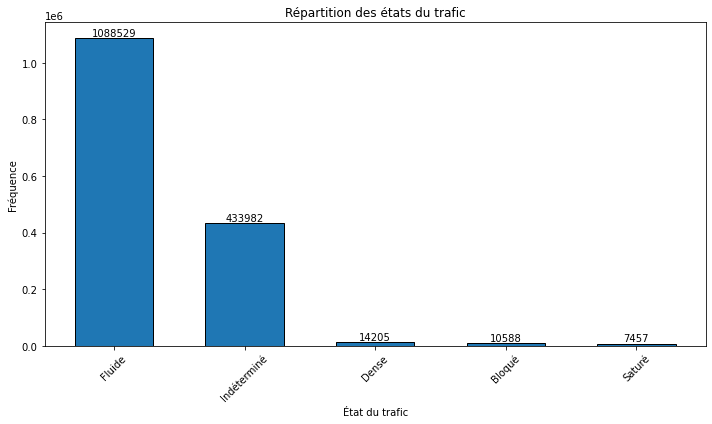

In [85]:
# Compter les occurrences de chaque état de trafic
counts = df_final['etat_du_trafic'].value_counts()

# Créer le graphique
plt.figure(figsize=(10, 6))
bars = plt.bar(counts.index, counts.values, width=0.6, edgecolor='black')

# Ajouter les étiquettes de données sur chaque barre
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), 
             ha='center', va='bottom', fontsize=10)

# Ajouter les titres et étiquettes
plt.title('Répartition des états du trafic')
plt.xlabel('État du trafic')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [90]:
# Compter les observations par tronçon
troncon_counts = df_final['nom_du_troncon'].value_counts()

# Calcul de la moyenne
moyenne_obs = troncon_counts.mean()

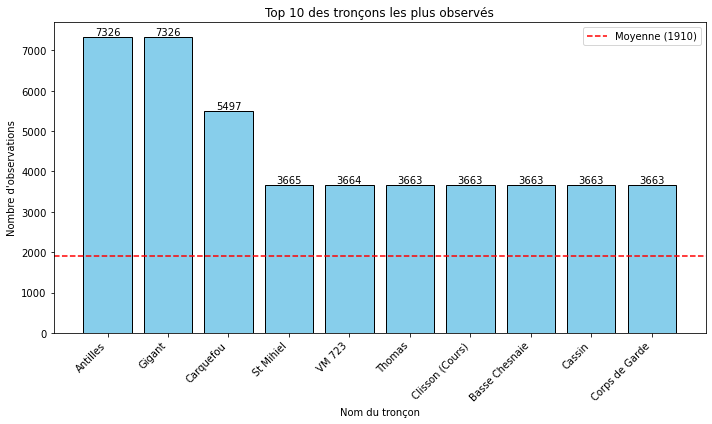

In [91]:

# Top 10 tronçons
top_10 = troncon_counts.head(10)

plt.figure(figsize=(10, 6))
bars = plt.bar(top_10.index, top_10.values, color='skyblue', edgecolor='black')

# Ligne de la moyenne
plt.axhline(moyenne_obs, color='red', linestyle='--', label=f'Moyenne ({moyenne_obs:.0f})')

# Étiquettes
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2,
             str(bar.get_height()), ha='center', va='bottom')

plt.title('Top 10 des tronçons les plus observés')
plt.xlabel('Nom du tronçon')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


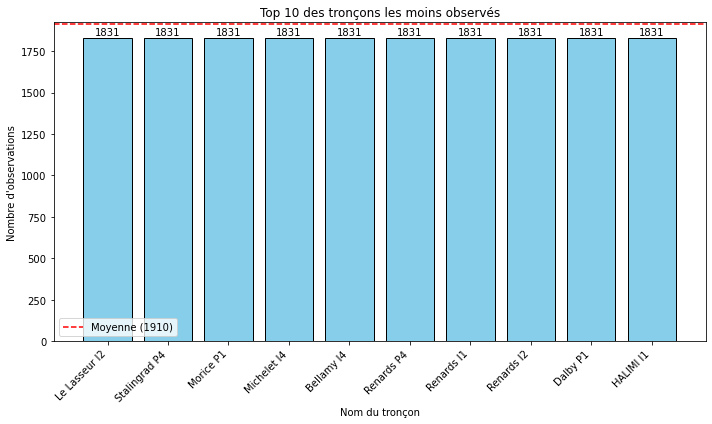

In [93]:
# Top 10 tronçons
top_10 = troncon_counts.tail(10)

plt.figure(figsize=(10, 6))
bars = plt.bar(top_10.index, top_10.values, color='skyblue', edgecolor='black')

# Ligne de la moyenne
plt.axhline(moyenne_obs, color='red', linestyle='--', label=f'Moyenne ({moyenne_obs:.0f})')

# Étiquettes
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2,
             str(bar.get_height()), ha='center', va='bottom')

plt.title('Top 10 des tronçons les moins observés')
plt.xlabel('Nom du tronçon')
plt.ylabel('Nombre d\'observations')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


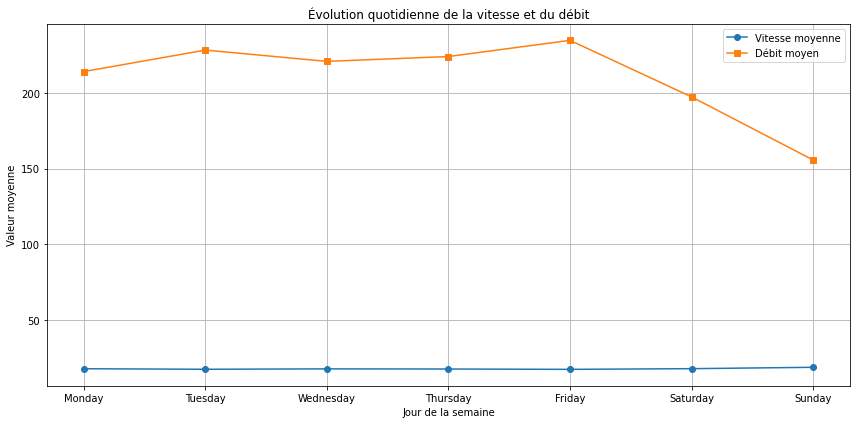

In [95]:
# Définir l’ordre naturel des jours
ordre_jours = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Grouper par jour et trier dans l'ordre souhaité
moyennes_jour = df_final.groupby('jour')[['vitesse', 'debit']].mean()
moyennes_jour = moyennes_jour.reindex(ordre_jours)

# Tracer
plt.figure(figsize=(12, 6))
plt.plot(moyennes_jour.index, moyennes_jour['vitesse'], label='Vitesse moyenne', marker='o')
plt.plot(moyennes_jour.index, moyennes_jour['debit'], label='Débit moyen', marker='s')

plt.title('Évolution quotidienne de la vitesse et du débit')
plt.xlabel('Jour de la semaine')
plt.ylabel('Valeur moyenne')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-96-c4c92d00b603>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['horodatage'] = pd.to_datetime(df_final['horodatage'])
<ipython-input-96-c4c92d00b603>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['heure'] = df_final['horodatage'].dt.hour


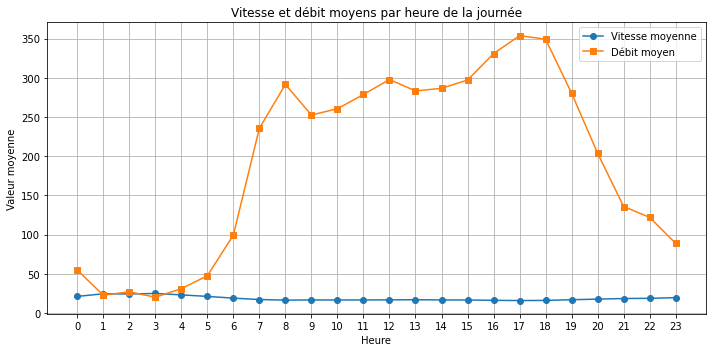

In [ ]:
# Extraire l'heure
df_final['heure'] = df_final['horodatage'].dt.hour

# Moyenne par heure
moyennes_heure = df_final.groupby('heure')[['vitesse', 'debit']].mean()

# Tracer
plt.figure(figsize=(10, 5))
plt.plot(moyennes_heure.index, moyennes_heure['vitesse'], marker='o', label='Vitesse moyenne')
plt.plot(moyennes_heure.index, moyennes_heure['debit'], marker='s', label='Débit moyen')

plt.title('Vitesse et débit moyens par heure de la journée')
plt.xlabel('Heure')
plt.ylabel('Valeur moyenne')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Extraire l'heure (0 à 23)
df_final['heure'] = df_final['horodatage'].dt.hour

# Grouper par jour + heure → moyennes de vitesse et débit
moyennes_par_heure_jour = df_final.groupby(['jour', 'heure'])[['vitesse', 'debit']].mean().reset_index()

# Ordonner les jours correctement
ordre_jours = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
moyennes_par_heure_jour['jour'] = pd.Categorical(moyennes_par_heure_jour['jour'], categories=ordre_jours, ordered=True)

# Trier le DataFrame
moyennes_par_heure_jour = moyennes_par_heure_jour.sort_values(['jour', 'heure'])


<ipython-input-97-7790e5f848a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['horodatage'] = pd.to_datetime(df_final['horodatage'])
<ipython-input-97-7790e5f848a7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['heure'] = df_final['horodatage'].dt.hour


<ipython-input-106-06f8ec0b0c23>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['horodatage'] = pd.to_datetime(df_final['horodatage'])
<ipython-input-106-06f8ec0b0c23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['heure'] = df_final['horodatage'].dt.hour


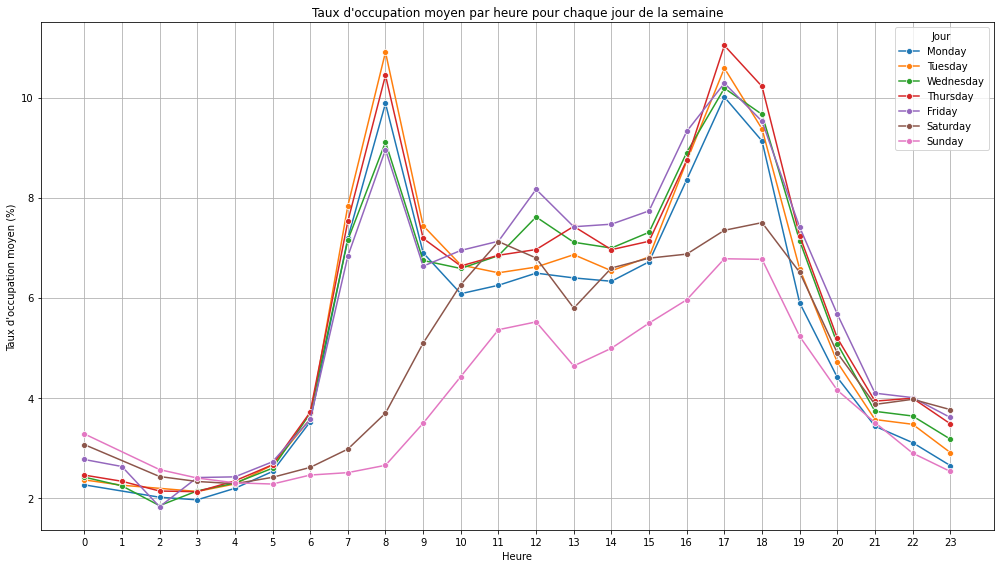

In [106]:
# S'assurer du bon format
df_final['horodatage'] = pd.to_datetime(df_final['horodatage'])
df_final['heure'] = df_final['horodatage'].dt.hour

# Ordre naturel des jours
ordre_jours = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Grouper par jour + heure → moyenne du taux d'occupation
occupation_par_heure_jour = df_final.groupby(['jour', 'heure'])['taux_occupation'].mean().reset_index()
occupation_par_heure_jour['jour'] = pd.Categorical(occupation_par_heure_jour['jour'], categories=ordre_jours, ordered=True)
occupation_par_heure_jour = occupation_par_heure_jour.sort_values(['jour', 'heure'])

# Tracer
plt.figure(figsize=(14, 8))
sns.lineplot(data=occupation_par_heure_jour, x='heure', y='taux_occupation', hue='jour', marker='o')

plt.title('Taux d\'occupation moyen par heure pour chaque jour de la semaine')
plt.xlabel('Heure')
plt.ylabel('Taux d\'occupation moyen (%)')
plt.xticks(ticks=range(0, 24), labels=[str(h) for h in range(0, 24)])
plt.grid(True)
plt.legend(title='Jour')
plt.tight_layout()
plt.show()


# Etudier les heures de pointes

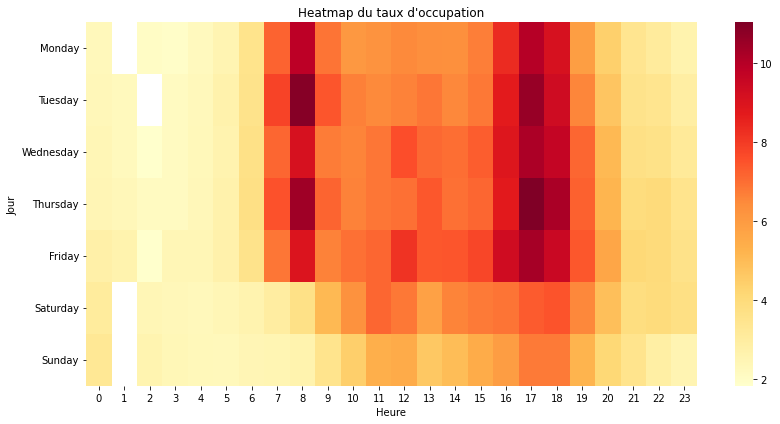

In [108]:
# Moyenne taux_occupation par heure et jour
heat_data = df_final.groupby(['jour', 'heure'])['taux_occupation'].mean().unstack()

# Trier les jours dans le bon ordre
ordre_jours = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heat_data = heat_data.reindex(ordre_jours)

# Afficher la heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heat_data, cmap='YlOrRd', annot=False)
plt.title('Heatmap du taux d\'occupation')
plt.xlabel('Heure')
plt.ylabel('Jour')
plt.tight_layout()
plt.show()


# Tronçons les plus fluctuannts

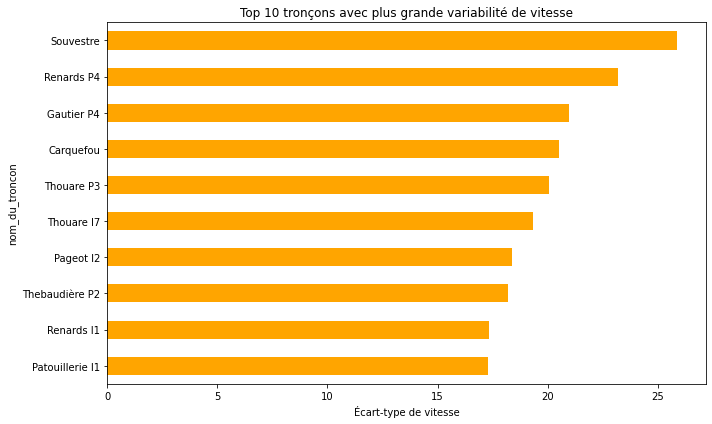

In [110]:
# Ecart-type
fluctuation = df_final.groupby('nom_du_troncon')[['vitesse', 'debit']].std()

# Top 10 les plus variables
top_fluctuation = fluctuation.sort_values('vitesse', ascending=False).head(10)

top_fluctuation['vitesse'].plot(kind='barh', figsize=(10, 6), color='orange')
plt.title('Top 10 tronçons avec plus grande variabilité de vitesse')
plt.xlabel('Écart-type de vitesse')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Impact evenements sur la circulation

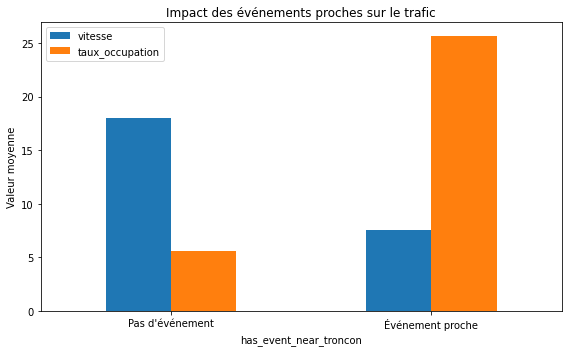

In [111]:
# Comparaison avec et sans événement
event_impact = df_final.groupby('has_event_near_troncon')[['vitesse', 'taux_occupation']].mean()

event_impact.plot(kind='bar', figsize=(8, 5), rot=0)
plt.title('Impact des événements proches sur le trafic')
plt.ylabel('Valeur moyenne')
plt.xticks([0, 1], ['Pas d\'événement', 'Événement proche'])
plt.tight_layout()
plt.show()


# Impact de la pluie sur le trafic

<ipython-input-112-b1d4d178fc47>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['pluie'] = df_final['precipitation'] > 0


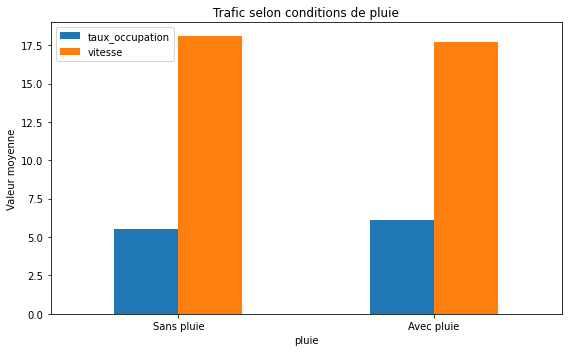

In [112]:
# Ajouter une colonne pluie oui/non
df_final['pluie'] = df_final['precipitation'] > 0

# Moyenne par condition météo
moy_pluie = df_final.groupby('pluie')[['taux_occupation', 'vitesse']].mean()

moy_pluie.plot(kind='bar', figsize=(8, 5), rot=0)
plt.title('Trafic selon conditions de pluie')
plt.ylabel('Valeur moyenne')
plt.xticks([0, 1], ['Sans pluie', 'Avec pluie'])
plt.tight_layout()
plt.show()


# Impact vacances/férié sur trafic/weekend

<ipython-input-122-ebfc0036f9f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['jour'] = df_final['jour'].str.capitalize()
<ipython-input-122-ebfc0036f9f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['is_weekend'] = df_final['jour'].isin(['Saturday', 'Sunday'])


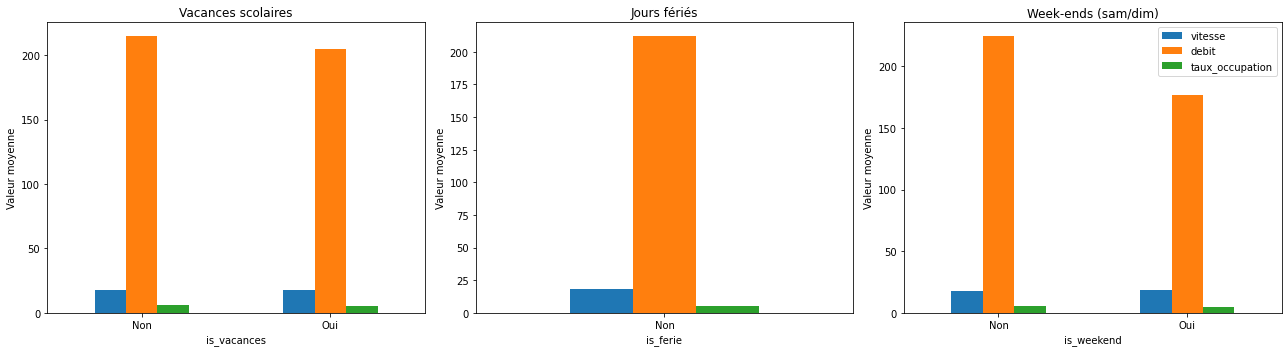

In [122]:
# Ajouter colonne weekend
df_final['jour'] = df_final['jour'].str.capitalize()
df_final['is_weekend'] = df_final['jour'].isin(['Saturday', 'Sunday'])

# Moyennes
vacances = df_final.groupby('is_vacances')[['vitesse', 'debit', 'taux_occupation']].mean()
feries = df_final.groupby('is_ferie')[['vitesse', 'debit', 'taux_occupation']].mean()
weekend = df_final.groupby('is_weekend')[['vitesse', 'debit', 'taux_occupation']].mean()

# Tracé
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (df_cond, title) in enumerate(zip(
    [vacances, feries, weekend],
    ['Vacances scolaires', 'Jours fériés', 'Week-ends (sam/dim)']
)):
    df_cond.plot(kind='bar', ax=axes[i], title=title, rot=0, legend=(i==2))
    axes[i].set_ylabel('Valeur moyenne')
    
    # Adapter les labels selon la taille réelle
    labels = ['Non', 'Oui'] if len(df_cond) == 2 else ['Oui'] if df_cond.index[0] else ['Non']
    axes[i].set_xticklabels(labels)

plt.tight_layout()
plt.show()

# Impact du trafic sur la pollution

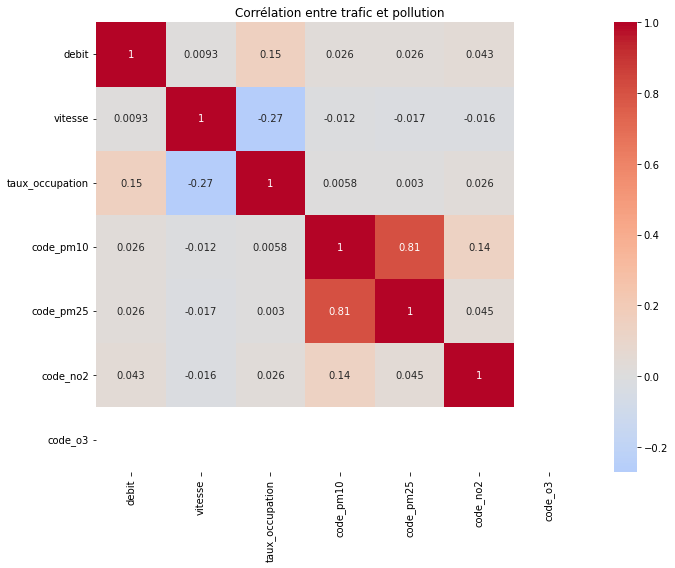

In [120]:
# Variables à étudier
vars_corr = ['debit', 'vitesse', 'taux_occupation', 'code_pm10', 'code_pm25', 'code_no2', 'code_o3']

plt.figure(figsize=(10, 8))
sns.heatmap(df_final[vars_corr].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Corrélation entre trafic et pollution')
plt.tight_layout()
plt.show()


In [ ]:
df_final['code_o3'].value_counts()

# Cleaning

## Suppression des valeurs 'indeterminé' dans la BDD

In [125]:
df_final.loc[:, 'etat_du_trafic'] = df_final['etat_du_trafic'].str.lower()
df_final = df_final[df_final['etat_du_trafic'] != 'indéterminé']

In [126]:
print(df_final['etat_du_trafic'].unique())

['fluide' 'dense' 'saturé' 'bloqué']


In [130]:
df_final.isna().sum().sort_values()

id_technique              0
date_dif                  0
source                    0
type_zone                 0
code_zone                 0
lib_zone                  0
code_no2                  0
code_so2                  0
code_o3                   0
code_pm10                 0
code_pm25                 0
coul_qual                 0
x_wgs84                   0
x_reg                     0
y_reg                     0
epsg_reg                  0
etat_indice               0
geom_type                 0
geom_coordinates          0
geo_point_2d_lon          0
geo_point_2d_lat          0
has_event_near_troncon    0
heure                     0
y_wgs84                   0
lib_qual                  0
code_qual                 0
date_ech                  0
id                        0
debit                     0
longueur                  0
taux_occupation           0
code_couleur              0
nom_du_troncon            0
etat_du_trafic            0
temps_de_parcours         0
vitesse             

# Sauvegarder la table en base

In [ ]:
# engine = create_engine(DATABASE_URL)
# df_final.to_sql('table_final', con=engine, if_exists='replace', index=False)

427